# Model Evaluation

In [1]:
# import required modules
import warnings
warnings.filterwarnings('ignore')

import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import pearsonr
from scipy.stats import ttest_1samp
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

import seaborn.apionly as sns
sns.set_context("poster")
from IPython.display import display
matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
# we define a function to calculate the Concordance Correlation Coefficient (a measure to evaluate our models)
def ccc_function(y,y_hat):
    pcc, _ = pearsonr(y_hat,y)
    ccc = 2 * pcc * y.std() * y_hat.std()/(y.var() + y_hat.var() + (y.mean() - y_hat.mean())**2)
    return ccc
# function to evaluate our quantitative models and store the result in a summary dictionary
def evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary):
    # input:
    # y_train,y_hat_train,y_test,y_hat_test
    # summary: dictionary with fields model name, R2train, R2test, PCC and CCC
    pcc, _ = pearsonr(y_test,y_hat_test)
    ccc = ccc_function(y_test,y_hat_test)
    r2train = r2_score(y_train,y_hat_train)
    r2test = r2_score(y_test,y_hat_test)
    summary['model name'].append(name)
    summary['R2train'].append(r2train)
    summary['R2test'].append(r2test)
    summary['PCC'].append(pcc)
    summary['CCC'].append(ccc)
    return r2train,r2test,pcc,ccc,summary

# set up a summary dictionary
summary = {'model name':[],'R2train':[],'R2test':[],"PCC":[],'CCC':[]}


## Model Performance Comparison
  
  
To evaluate our models, we used 3 different metrics: R2 score, Pearson's correlation coefficient (PCC) and Concordance correlation coefficient (CCC), all on the test set. The latter is the metric used in the AD DREAM challenge to score the leaderboard.

In [3]:
with open('mmse_data2.pickle', 'rb') as f:
    (X_train,X_test,y_train,y_test,y_dx_train,y_dx_test,summary,gbr_est) = pickle.load(f)
display(pd.DataFrame(summary)[['model name','R2train','R2test','PCC','CCC']])

,model name,R2train,R2test,PCC,CCC
0,linear regression with all predictors,1.000000,-0.575704,0.292637,0.291248
1,linear regression on 197 PCs,0.607145,0.146130,0.462699,0.434770
2,ridge regression with 197 PCs,0.471062,0.265014,0.518424,0.419588
3,Elastic Net regression with 197 PCs,0.430632,0.267113,0.520643,0.415252
4,linear regression with 20 PCs,0.321961,0.226916,0.486073,0.415090
5,linear regression with 5 predictors,0.347888,0.263385,0.522998,0.457284
6,linear regression model with Ridge regularizat...,0.346355,0.267639,0.522654,0.441700
7,Random Forest Regressor with all predictors,0.796740,0.240607,0.497886,0.351548
8,gradient boosting regressor with all predictors,0.996073,0.289511,0.538661,0.458527


The best model in all 3 evaluation metrics (R2 score, Pearson's correlation coefficient, Concordance correlation coefficient, all on test set) is the gradient boosting regressor. Assuming our test set is representative of the test set used for the AD DREAM challenge, our Concordance correlation coefficient of 0.47 would place us on rank 8 of the [final leaderboard](https://www.synapse.org/#!Synapse:syn2290704/wiki/68513). The Pearson's correlation coefficient would place us even higher. We use our optimal model to visualize how our predicted MMSE scores compare to the true MMSE scores, both on the training set and test set. We also visualize the different diagnoses classes (CN = control, MCI = mild cognitive impairment and AD = Alzheimer's disease) in these diagrams.

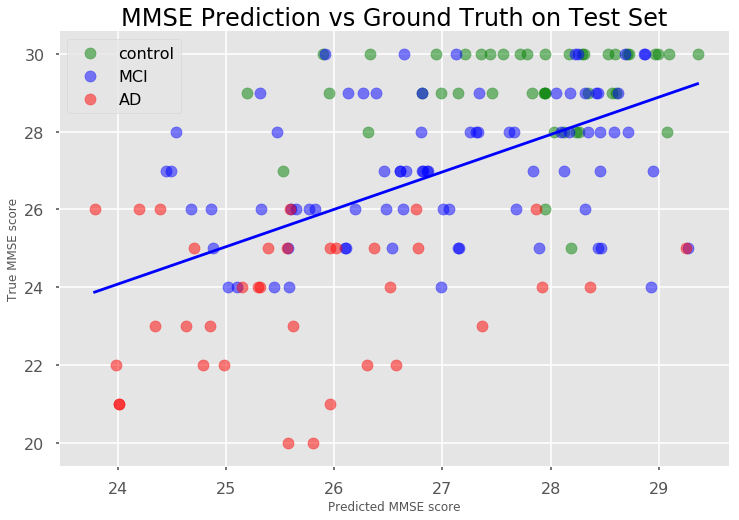

In [4]:
# visualization of the best model 

y_hat_train = gbr_est.predict(X_train)
y_hat_test = gbr_est.predict(X_test)

# plot of prediction vs truth on test set
idx1 = y_dx_test == 0
idx2 = y_dx_test == 1
idx3 = y_dx_test == 2

fig7 = plt.figure(figsize = [12,8])
plt.scatter(y_hat_test[idx1],y_test[idx1],alpha=0.5,c='green')
plt.scatter(y_hat_test[idx2],y_test[idx2],alpha=0.5,c='blue')
plt.scatter(y_hat_test[idx3],y_test[idx3],alpha=0.5,c='red')

plt.xlabel('Predicted MMSE score')
plt.ylabel('True MMSE score')
plt.legend(['control','MCI','AD'])
plt.title('MMSE Prediction vs Ground Truth on Test Set',fontsize=24)

#plot regression line
beta1,beta0 = np.polyfit(y_hat_test,y_test,deg=1)
f = lambda x: beta1 * x + beta0
x = np.array([np.min(y_hat_test), np.max(y_hat_test)])
plt.plot(x,f(x),c='blue')

sns.despine()

Based on the distribution of different diagnosis classes in this graph, it should be possible to use the predicted MMSE in the prediction of diagnoses.

## Influence of estimated MMSE on diagnosis prediction
  
  
We are first comparing three simple logistic regression classifiers: One that uses only the demographic data for predicting diagnosis, one that uses the actual MMSE score and one that uses our predicted MMSE score. The first achieves only 46% accuracy on the test set, whereas the second achieves 69%. The model with our predicted MMSE score is halfway between these 2 extremes with 56% accuracy.

In [5]:
# try to predict diagnosis based on demographic predictors only (logistic regression with xval for regularization)
demographic_columns = ['AGE','PTGENDER','PTEDUCAT','PTETHCAT','imputed_genotype','PTRACCAT_Black','PTRACCAT_White','APOE4_1','APOE4_2']


X_est_train = X_train[demographic_columns].copy()
X_est_test = X_test[demographic_columns].copy()

Cs = [100000,50000,10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
logreg_clf = LogisticRegressionCV(Cs=Cs)
logreg_clf.fit(X_est_train,y_dx_train)
y_hatdx_train = logreg_clf.predict(X_est_train)
y_hatdx_test = logreg_clf.predict(X_est_test)

train_acc = np.sum(y_hatdx_train == y_dx_train)/len(y_dx_train)
test_acc = np.sum(y_hatdx_test == y_dx_test)/len(y_dx_test)

print('model with demographic factors only:')
print('training accuracy: ',train_acc)
print('test accuracy: ', test_acc)

model with demographic factors only:
training accuracy:  0.511677282378
test accuracy:  0.464968152866


In [6]:
# new model based on demographic predictors + true MMSE score
X_est_train['MMSE'] = y_train
X_est_test['MMSE'] = y_test

Cs = [100000,50000,10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
logreg_clf = LogisticRegressionCV(Cs=Cs)
logreg_clf.fit(X_est_train,y_dx_train)
y_hatdx_train = logreg_clf.predict(X_est_train)
y_hatdx_test = logreg_clf.predict(X_est_test)

train_acc = np.sum(y_hatdx_train == y_dx_train)/len(y_dx_train)
test_acc = np.sum(y_hatdx_test == y_dx_test)/len(y_dx_test)

print('model with demographic factors + true MMSE score:')
print('training accuracy: ',train_acc)
print('test accuracy: ', test_acc)

model with demographic factors + true MMSE score:
training accuracy:  0.713375796178
test accuracy:  0.694267515924


In [7]:
# new model based on demographic predictors + our predicted MMSE score
X_est_train['MMSE'] = y_hat_train
X_est_test['MMSE'] = y_hat_test

Cs = [100000,50000,10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
logreg_clf = LogisticRegressionCV(Cs=Cs)
logreg_clf.fit(X_est_train,y_dx_train)
y_hatdx_train = logreg_clf.predict(X_est_train)
y_hatdx_test = logreg_clf.predict(X_est_test)

train_acc = np.sum(y_hatdx_train == y_dx_train)/len(y_dx_train)
test_acc = np.sum(y_hatdx_test == y_dx_test)/len(y_dx_test)

print('model with demographic factors + our estimated MMSE score:')
print('training accuracy: ',train_acc)
print('test accuracy: ', test_acc)

model with demographic factors + our estimated MMSE score:
training accuracy:  0.71974522293
test accuracy:  0.56050955414


In order to getter a better estimate and a significance value for the improvement, we perform bootstrapping by resampling our training set with replacement, use the remaining observations as test set and determine the difference in test accuracies between the base model and our (putatively) improved model.

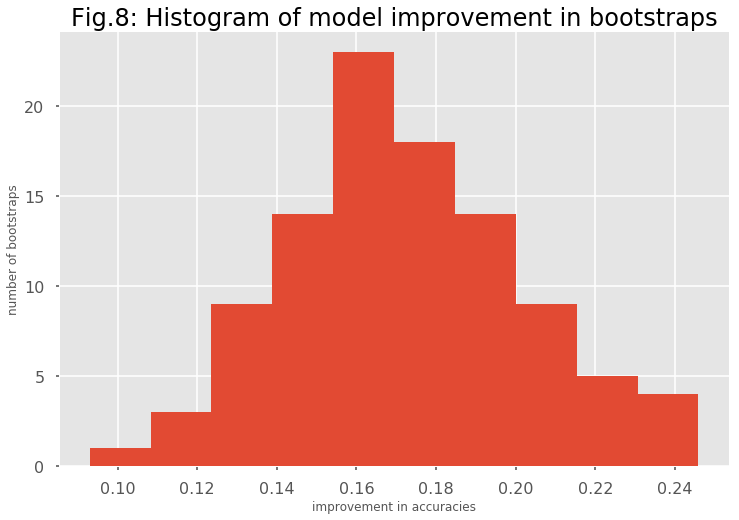

In [8]:
# get p-values for the effect of estimated mmse score using a paired t-test (one sample t-test on differences)
num_iterations = 100
train_size = X_est_train.shape[0]
data = pd.concat([pd.concat([X_est_train,X_est_test]),pd.concat([y_dx_train,y_dx_test])],axis=1).values

test_acc_diffs = []

for i in range(num_iterations):
    # prepare train and test sets
    train = resample(data, n_samples=train_size)
    test = np.array([x for x in data if x.tolist() not in train.tolist()])
    X_train_bs = train[:,:-1]
    y_train_bs = train[:,-1]
    X_test_bs = test[:,:-1]
    y_test_bs = test[:,-1]
    
    # fit base model without mmse
    logreg_clf = LogisticRegressionCV(Cs=Cs)
    logreg_clf.fit(X_train_bs[:,:-1],y_train_bs)
    y_hat_base = logreg_clf.predict(X_test_bs[:,:-1])
    acc_base = np.sum(y_hat_base == y_test_bs)/len(y_test_bs)
    
    # fit mmse model 
    logreg_clf.fit(X_train_bs,y_train_bs)
    y_hat_mmse = logreg_clf.predict(X_test_bs)
    acc_mmse = np.sum(y_hat_mmse == y_test_bs)/len(y_test_bs)
    
    test_acc_diffs.append(acc_mmse - acc_base)

fig8 = plt.figure(figsize = [12,8])
plt.hist(test_acc_diffs)
plt.xlabel('improvement in accuracies')
plt.ylabel('number of bootstraps')
plt.title('Fig.8: Histogram of model improvement in bootstraps',fontsize=24);

In [9]:
_,pval = ttest_1samp(test_acc_diffs,popmean=0)
print('mean improvement by inclusion of predicted MMSE score: ',np.mean(test_acc_diffs))
print('Null Hypothesis: Including predicted MMSE has no effect on accuracy of classifier')
print('p-value: ', pval)

mean improvement by inclusion of predicted MMSE score:  0.172099557385
Null Hypothesis: Including predicted MMSE has no effect on accuracy of classifier
p-value:  7.61810278112e-78


The improvement in test accuracies appears roughly normally distributed and has a mean of 17%. Based on a paired t-test, these effects are highly significant.

## Discussion
  
  
We have shown that our best models can compete with other submissions to the AD DREAM challenge and even outperform 2/3 of the submissions. We have also shown that the predicted MMSE scores from our best model are good enough to significantly improve Alzheimer's Disease/Dementia diagnosis. However, given more time, there might be ways to further improve our model: We currently use preprocessed geometrical data to approximate brain morphology as our predictors; the raw MRI data might contain information that is not captured by this data. Training a deep neural net on raw MRI images might improve our prediction.  
It is remarkable that a number of our models is performing relatively well. Combining these models by stacking might further improve our prediction.